In [44]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import re
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# import contextily as cx
import branca.colormap as cm

In [45]:
# Start a SparkSessions
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 Data Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

# Data Preprocessing

According to the information, provided by NYC TLC on [taxi fare](!https://home.nyc.gov/site/tlc/passengers/taxi-fare.page), the latest update on fare was December 19, 2022. Though, the last updated dates for the dictionaries of trip records for green and yellow taxis were all prior to this update. Thus, we will be using the dictionaries as a guideline for what each field represents. However, any specificiation on money-related charges in the dictionaries that are not consistent with the taxi fare information will be changed.

The data pre-processing stage is based on Tan's approach in MAST30034 2022 Sample Solution. We then add additional steps on top of this approach so that the data aligns better to our research goal.

## TLC Data

In [47]:
from pyspark.sql.types import DoubleType

def basic_data_cleaning(df, service):
    """
        This function performance basic data cleaning (i.e. removing null or inconsistent entries) accordingly with the dictionary provided for the dataset
            "VendorID": 2 vendors - 1: Creative Mobile Technologes, LLC ; 2: VeriFone Inc.
            "tpep_pickup_datetime", "tpep_dropoff_datetime": Ensure data entries are within the specified range when download the data and trip duration not negative
            "passenger_count": Passenger count should be > 0
            "trip_distance": Distance must be > 0.5 miles
            "RatecodeID": Numeric code ranging from 1-6
            "store_and_fwd_flag": 2 code Y-N
            "PULocationID", "DOLocationID": Numeric code ranging from from 1-263
            "payment_type": Numeric code ranging from 1-6
            "extra": Minumum $0.00
            "mta_tax": $0.00 for trips ended at EWC or $0.50 for trips end in NYC
            "tips_amount", "tolls_amount", "congestion_surcharge": Minimum $0.00
            "total_amount": Minimum $3.00
            "improvement_surcharge": fixed charge $1.00
            "airport_fee": $1.75 for pick up only at LGA and JFK Airports
    """
    intial_entries_count = df.count()
    print(f"Starting number of entries: {intial_entries_count}")

    if service == "green":
    # For green trip records only. "ehail_fee" is always NULL (), thus we're removing that column as it has no valuable meaning
        df = df.drop(F.col("ehail_fee"))
        df = df.drop(F.col("trip_type"))
        df = df.withColumn("airport_fee", F.lit(0.00).cast(DoubleType())) # add this column so that both dataset has conformable format for merging
        df = df.withColumn("taxi_type", F.lit(2))
    elif service =="yellow":
        df = df.withColumnRenamed("Airport_fee", "airport_fee")    
        df = df.withColumn("taxi_type", F.lit(1))

    columns = df.columns
    
    # Renaming columns to conformable format for merging
    for col in columns:
        if re.search(r"(l|t)pep_pickup_datetime", col):
            df = df.withColumnRenamed(col, "pickup_datetime")
        elif re.search(r"(l|t)pep_dropoff_datetime", col):
            df = df.withColumnRenamed(col, "dropoff_datetime")

    # Remove entries with invalid value for VendorID
    df = df.filter((F.col('VendorID') == 1) | (F.col('VendorID') == 2))

    # Filter records that falls out of our research range and splitting datetime into month and day
    start_date = "2023-03-01"
    end_date = "2024-05-31"
    df = df.filter((start_date <= F.to_date("pickup_datetime")) & (F.to_date("pickup_datetime") <= end_date))
    df = df.filter((start_date <= F.to_date("dropoff_datetime")) & (F.to_date("dropoff_datetime") <= end_date))

    # Remove entries with negative trip duration or less than 1 minute of travelling
    df = df.withColumn("trip_duration", (F.unix_timestamp(F.col("dropoff_datetime")) - F.unix_timestamp(F.col("pickup_datetime")))/60)
    df = df.withColumn("trip_duration",F.round(F.col("trip_duration"),2))
    df = df.filter(F.col('trip_duration') >= 1)

    # Remove entries with invalid passenger count
    df = df.filter((F.col('passenger_count') > 0) & (F.col('passenger_count').isNotNull()))

    # Remove entries with < 0.5 mile trip distance. Assuming passenger would rather walk the distance
    df = df.filter(F.col('trip_distance') >= 0.5)
    
    # Remove entries with invalid RatecodeID
    df = df.filter((F.col("RatecodeID") == 1) | (F.col("RatecodeID") == 2) |
                   (F.col("RatecodeID") == 3) | (F.col("RatecodeID") == 4) |
                   (F.col("RatecodeID") == 5) | (F.col("RatecodeID") == 6))
    
    # Remove entries with invalid store_and_fwd_flag value
    df = df.filter((F.col("store_and_fwd_flag") == "Y") | (F.col("store_and_fwd_flag") == "N"))

    # Remove entries with invalid PULocationID and DOLocationID
    df = df.filter(((1 <= F.col("PULocationID")) & (F.col("PULocationID") <= 263) & (F.col("PULocationID").isNotNull())) &
                   ((1 <= F.col("DOLocationID")) & (F.col("DOLocationID") <= 263) & (F.col("PULocationID").isNotNull())))
    
    # Remove entries with invalid payment type
    df = df.filter((F.col("payment_type") == 1) | (F.col("payment_type") == 2) |
                   (F.col("payment_type") == 3) | (F.col("payment_type") == 4) |
                   (F.col("payment_type") == 5) | (F.col("payment_type") == 6))

    # Remove entries with negative value for "extra" as the minimum is $0.00
    df = df.filter(F.col("extra") >= 0)

    # Remove entries with inconsistent values for "mta_tax"
    df = df.filter(
        ((F.col('mta_tax') == 0.0 ) & (F.col('DOLocationID') == 1)) |
        ((F.col('mta_tax') == 0.5) & (F.col('DOLocationID') != 1)) 
    )

    # Remove entries with negative values in "tip_amount", "tolls_amount", "congestion_surcharge"
    df = df.filter((F.col("tip_amount") >= 0) &
                   (F.col("tolls_amount") >= 0) &
                   (F.col("congestion_surcharge") >= 0))
    
    # Remove entries with < $3.00 total amount
    df = df.filter(F.col("total_amount") >= 3.00)

    # Remove entries with "improvement_surcharge" != $1.00 as this field value is always $1.00
    df = df.filter(F.col("improvement_surcharge") == 1)

    # Remove entries with airport fee different from $0.00 or $1.75
    df = df.filter((F.col("airport_fee") == 0) | (F.col("airport_fee") == 1.75))

    final_entries_count = df.count()
    percentage_removed = round(((intial_entries_count - final_entries_count)/intial_entries_count) * 100, 2)
    print(f"Removed {intial_entries_count - final_entries_count} ({percentage_removed}) \nRemaining entries: {final_entries_count}" )
    return df


### Cleaning yellow trips records

In [51]:
# Yellow data
yellow_df = spark.read.parquet("../data/raw/yellow")
initial_rows = yellow_df.count()

In [52]:
# Clean yellow_df
yellow_df = basic_data_cleaning(yellow_df, "yellow")

Starting number of entries: 49122405


Removed 7446157 (15.16) 
Remaining entries: 41676248


Splitting into train and test data

In [53]:
# Train data
yellow_train = yellow_df.filter((( "2023-03-01" <= F.to_date(F.col('pickup_datetime'))) & (F.to_date(F.col('pickup_datetime')) <= "2024-02-29" )) &
                                (( "2023-03-01" <= F.to_date(F.col('dropoff_datetime'))) & (F.to_date(F.col('dropoff_datetime')) <= "2024-02-29" )))

# Test data
yellow_test = yellow_df.filter((( "2024-03-01" <= F.to_date(F.col('pickup_datetime'))) & (F.to_date(F.col('pickup_datetime')) <= "2024-05-31" )) &
                                (( "2024-03-01" <= F.to_date(F.col('dropoff_datetime'))) & (F.to_date(F.col('dropoff_datetime')) <= "2024-05-31" )))

### Cleaning green trips records

In [54]:
# Loading green data
green_df = spark.read.parquet("../data/raw/green")
initial_rows = initial_rows + green_df.count()

In [55]:
green_df = basic_data_cleaning(green_df, "green")

Starting number of entries: 939099
Removed 260906 (27.78) 
Remaining entries: 678193


Splitting into train and test data

In [57]:
# Train data
green_train = green_df.filter((( "2023-03-01" <= F.to_date(F.col('pickup_datetime'))) & (F.to_date(F.col('pickup_datetime')) <= "2024-02-29" )) &
                                (( "2023-03-01" <= F.to_date(F.col('dropoff_datetime'))) & (F.to_date(F.col('dropoff_datetime')) <= "2024-02-29" )))

# Test data
green_test = green_df.filter((( "2024-03-01" <= F.to_date(F.col('pickup_datetime'))) & (F.to_date(F.col('pickup_datetime')) <= "2024-05-31" )) &
                                (( "2024-03-01" <= F.to_date(F.col('dropoff_datetime'))) & (F.to_date(F.col('dropoff_datetime')) <= "2024-05-31" )))

## Outlier Detection

For outlier detection, we will use a modified version of **Winsorizing** method which we will remove values that are above or below certain percentiles. The reason we're using it is because this method is efficient upon large dataset whereas methods such as IQR is not effective for dataset of this size. This is due to IQR assuming an underlying symmetric distribution, upon skewed distribution, the IQR is heavily affected by extremely large or small values, thus removing a lot of entries from our data

In [58]:
def outlier_filter(df, columns, lower, upper):
    initial_rows = df.count()

    for col in columns:
        lower_bound = df.select(F.percentile_approx(F.col(col), lower)).first()[0]
        upper_bound = df.select(F.percentile_approx(F.col(col), upper)).first()[0]

        df = df.filter((lower_bound <= F.col(col)) & (F.col(col) <= upper_bound))

    final_rows = df.count()
    row_diff = initial_rows - final_rows
    print(f"Starting number of entries: {initial_rows}")
    print(f"Removed: {row_diff} ({round((row_diff/initial_rows) * 100,2)})\nRemaining rows: {final_rows}")

    # pd_sample_df = df.sample(fraction=0.05, seed=42).select(*columns).toPandas()
    return df #, pd_sample_df

Applied outlier detection on all dataset

In [59]:
yellow_train = outlier_filter(yellow_train, ["trip_distance", "total_amount", "trip_duration"], 0.01, 0.99)

Starting number of entries: 33058506
Removed: 1845899 (5.58)
Remaining rows: 31212607


In [60]:
yellow_test = outlier_filter(yellow_test, ["trip_distance", "total_amount", "trip_duration"], 0.01, 0.99)

Starting number of entries: 8616729
Removed: 478344 (5.55)
Remaining rows: 8138385


In [61]:
green_train = outlier_filter(green_train, ["trip_distance", "trip_duration", "total_amount"], 0.01, 0.99)

Starting number of entries: 547309
Removed: 32238 (5.89)
Remaining rows: 515071


In [62]:
green_test = outlier_filter(green_test, ["trip_distance", "trip_duration", "total_amount"], 0.01, 0.99)

Starting number of entries: 130874
Removed: 7515 (5.74)
Remaining rows: 123359


In [65]:
print(f"Number of rows before data preprocessing: {initial_rows}")
print(f"Number of rows after data preprocessing: {yellow_test.count() + yellow_train.count() + green_test.count() + green_train.count()}")

Number of rows before data preprocessing: 50061504


Number of rows after data preprocessing: 39989422


# Feature Engineering

Since we suspect that there is a seasonal effect on taxi demands, we will generate another feature that indicate which season the entries belong to
```{python}
season = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter}
``` 

We will also split the columns `pickup_datetime` and  into `month` and  `day` (though, we not sure if `day` is going to be use, but we split it for now)



In [66]:
def season_assign(col):
    """
        Assign season to entries
    """
    col = F.month(col)
    return (F.when((col == 3) | (col == 4) | (col == 5), 1)\
        .when((col == 6) | (col == 7) | (col == 8), 2)\
        .when((col == 9) | (col == 10) | (col == 11), 3)\
        .when((col == 12) | (col == 1) | (col == 2),4))

def transform_datetime(df):
    """
        This function take a column with datetime formate and split them into 3 columns
            `pickup_month`, `pickup_date`, and `pickup_time`
        The function will also add 2 extra columns, indicating the season when the ride took place and if it's a weekday or not
            `weekday`, `season`
        The function will also drop off 2 columns
            `pickup_datetime` and `dropoff_datetime`
        and rearrange the columns for a better view
    """
    df = df.withColumns({"pickup_month": F.month(F.col("pickup_datetime")), 
                       "pickup_day": F.day(F.col("pickup_datetime")), 
                       "pickup_time": F.date_format(F.col("pickup_datetime"), "HH:mm:ss"),
                       "season": season_assign(F.col("pickup_datetime"))
                       })
    df = df.drop("pickup_datetime","dropoff_datetime")

    ordered_columns = ["VendorID", "season","pickup_month", "pickup_day","pickup_time", "taxi_type",
                   "trip_duration", "trip_distance", "RatecodeID", "store_and_fwd_flag", "PULocationID",
                   "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount",
                   "tolls_amount", "improvement_surcharge", "congestion_surcharge","airport_fee", "total_amount"]

    df = df.select(*ordered_columns)

    return df
    

Apply the feature engineering across all dataset

In [67]:
yellow_train = transform_datetime(yellow_train)

In [68]:
yellow_test = transform_datetime(yellow_test)

In [69]:
green_train = transform_datetime(green_train)

In [70]:
green_test = transform_datetime(green_test)

We assume that the type of taxi does not help us predict monthly demands. Thus we will merge datasets for both taxi type together.

In [71]:
# Merging train data
df_train = yellow_train.union(green_train)
df_train = df_train.withColumnRenamed("pickup_month", "month")

In [72]:
# Merging test data
df_test = yellow_test.union(green_test)
df_test = df_test.withColumnRenamed("pickup_month", "month")

We will also merge the trip record data with the weather and unemployment rate data

In [73]:
# Reading train and test data of external data
weather_train = spark.read.parquet("../data/curated/weather_train")
weather_test = spark.read.parquet("../data/curated/weather_test")

unemp_train = spark.read.parquet("../data/curated/unemp_train.parquet")
unemp_train = unemp_train.withColumnsRenamed({"Label": "month",
                                  "Value": "unemp_rate"})

unemp_test = spark.read.parquet("../data/curated/unemp_test.parquet")
unemp_test = unemp_test.withColumnsRenamed({"Label": "month",
                                  "Value": "unemp_rate"})

In [74]:
# Join the train data
df_train = df_train.join(weather_train, on="month", how="inner")
df_train = df_train.join(unemp_train, on="month", how = "inner")

In [75]:
# Join the test data
df_test = df_test.join(weather_test, on="month", how="inner")
df_test = df_test.join(unemp_test, on="month", how = "inner")

We assume that all fees-related column are capture inside the `total_fare`. Thus, we will drop the other fees-related column as well as other columns that are trip specific such as `store_and_fwd_flag`. Since we only care about trip demands, we don't need the dropoff location as it doesn't influence the taxi demands. Thus we will only use the pickup location ID and remove the dropoff location.

In [78]:
# Drop unnecessary columns in training data
df_train = df_train.drop("taxi_type", "RatecodeID", "DOLocationID", "store_and_fwd_flag",
             "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount",
             "tolls_amount", "improvement_surcharge", "congestion_surcharge",
             "airport_fee")

In [79]:
# Drop unnecessary columns in test data
df_test = df_test.drop("taxi_type", "RatecodeID", "DOLocationID", "store_and_fwd_flag",
             "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount",
             "tolls_amount", "improvement_surcharge", "congestion_surcharge",
             "airport_fee")

It's also important to have a look as the distribution of our numerical feature such as `total_amount`, `trip_distance`, and `trip_location`. As plotting the full data is not ideal, we will use stratified sampling to sample the data whilst keeping the represtation of each subgroup in the data. The subgroup are grouped by location, season, and month.

In [81]:
# Create a key column that combined the location, season, and month and later on use as key to represent the subgroup
# The aid of ChatGPT was use to help create the key for the subgroup
strat_df = df_train.withColumn("key", F.concat_ws("_", df_train['PULocationID'], 
                                 df_train['season'], df_train['month']))

# If subgroup have less than 100 entries, we wil use all of it. Otherwise, the rest are sample at 5% rate
group_count  = strat_df.groupBy("key").count()
group_count = group_count.select("key", "count").distinct().rdd\
    .map(lambda x: (x[0], x[1])).collectAsMap()

fractions = {key: 1
             if group_count[key] < 100 else 0.05
             for key in group_count}

# Get the sample
sample = strat_df.sampleBy("key", fractions=fractions, seed = 42)
sample = sample.drop("key")

In [82]:
# Convert to pandas dataframe for visualisation
sample_pd = sample.toPandas()

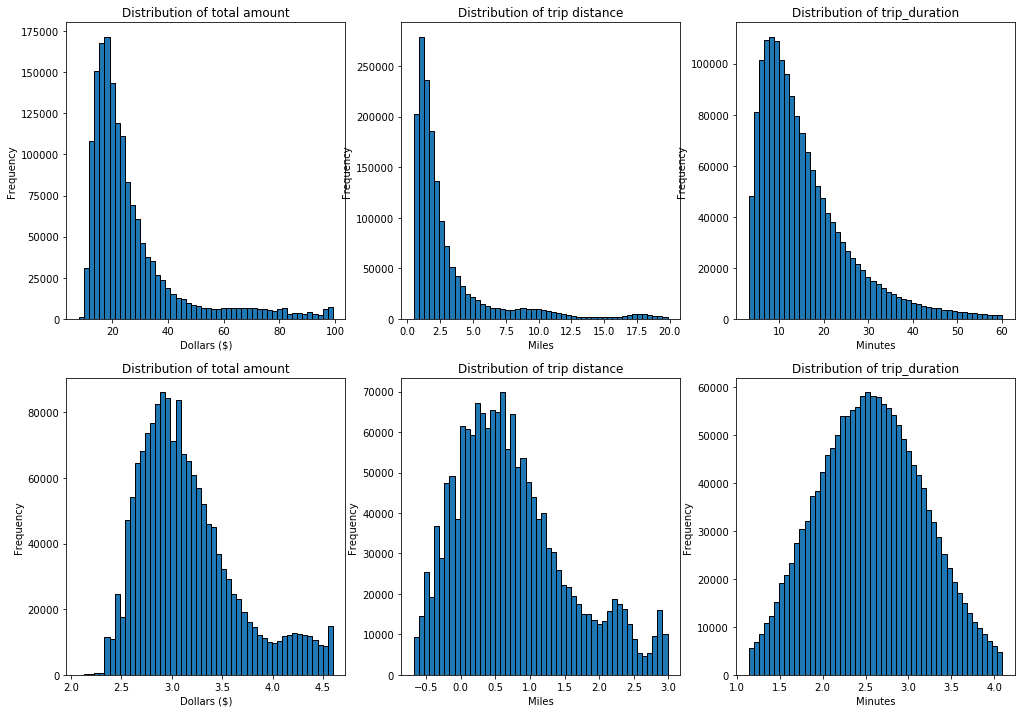

In [83]:
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17,12))

axs[0][0].hist(sample_pd['total_amount'], bins=50, edgecolor='black')
axs[0][0].set_title('Distribution of total amount')
axs[0][0].set_xlabel('Dollars ($)')
axs[0][0].set_ylabel('Frequency')

axs[0][1].hist(sample_pd['trip_distance'], bins=50, edgecolor='black')
axs[0][1].set_title('Distribution of trip distance')
axs[0][1].set_xlabel('Miles')
axs[0][1].set_ylabel('Frequency')

axs[0][2].hist(sample_pd['trip_duration'], bins=50, edgecolor='black')
axs[0][2].set_title('Distribution of trip_duration')
axs[0][2].set_xlabel('Minutes')
axs[0][2].set_ylabel('Frequency')

axs[1][0].hist(np.log(sample_pd['total_amount']), bins=50, edgecolor='black')
axs[1][0].set_title('Distribution of total amount')
axs[1][0].set_xlabel('Dollars ($)')
axs[1][0].set_ylabel('Frequency')

axs[1][1].hist(np.log(sample_pd['trip_distance']), bins=50, edgecolor='black')
axs[1][1].set_title('Distribution of trip distance')
axs[1][1].set_xlabel('Miles')
axs[1][1].set_ylabel('Frequency')

axs[1][2].hist((np.log(sample_pd['trip_duration'])), bins=50, edgecolor='black')
axs[1][2].set_title('Distribution of trip_duration')
axs[1][2].set_xlabel('Minutes')
axs[1][2].set_ylabel('Frequency')

plt.show()

From the plot above, it's vivid that the 3 features are heavily skewed and after applying log-transformation to the columns, it's look better. Thus, we will apply log-transformation to the both the test and train data


In [84]:
# Applying log to the designated columns
df_train = df_train.withColumns({"trip_duration": F.log(F.col("trip_duration")),
                "trip_distance": F.log(F.col("trip_distance")),
                "total_amount": F.log(F.col("total_amount"))})

df_train = df_train.withColumnsRenamed({
    "trip_duration": "log_duration",
    "trip_distance": "log_distance",
    "total_amount": "log_amount"
})

df_test = df_test.withColumns({"trip_duration": F.log(F.col("trip_duration")),
                "trip_distance": F.log(F.col("trip_distance")),
                "total_amount": F.log(F.col("total_amount"))})

df_test = df_test.withColumnsRenamed({
    "trip_duration": "log_duration",
    "trip_distance": "log_distance",
    "total_amount": "log_amount"
})

# Apply log to the designated columns in the sample
for col in ['total_amount', 'trip_duration', 'trip_distance']:
    sample_pd[col] = np.log(sample_pd[col])

sample_pd = sample_pd.rename({"trip_duration": "log_duration",
    "trip_distance": "log_distance",
    "total_amount": "log_amount"}, axis=1)

# Export curated data

We stored the dataset and the sampled data to curated folder for data analysis or visualisation

In [86]:
df_train.write.parquet("../data/curated/trip_records_train")
df_test.write.parquet("../data/curated/trip_records_test")
sample_pd.to_csv("../data/curated/sample.csv", index=False)